# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [1]:
# Update the PATH to include the user installation directory.
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

# Restart the Kernel before you move on to the next step.

#### Important: Restart the Kernel before you move on to the next step.

## Imports

In [2]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision.datasets as datasets


## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`!

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [3]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)

    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))

        image = images[i].numpy()
        plt.figure(figsize=(1, 1))
        plt.imshow(image.T.squeeze().T)
        plt.show()

## Data prepocessing

In [4]:
import os
from tqdm import tqdm

def compute_mean_and_std_mnist():
    """
    Compute mean and std of the MNIST dataset.
    """

    cache_file = "mean_and_std_mnist.pt"
    if os.path.exists(cache_file):
        print(f"Reusing cached mean and std for MNIST")
        d = torch.load(cache_file)
        return d["mean"], d["std"]

    # Load the MNIST dataset without any transformations first
    ds = datasets.MNIST(root="data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
    dl = torch.utils.data.DataLoader(ds, batch_size=1, num_workers=0)

    mean = 0.0
    for images, _ in tqdm(dl, total=len(ds), desc="Computing mean", ncols=80):
        mean += images.mean()

    mean /= len(ds)

    var = 0.0
    for images, _ in tqdm(dl, total=len(ds), desc="Computing std", ncols=80):
        var += ((images - mean) ** 2).sum()

    std = torch.sqrt(var / len(ds))

    # Cache results so we don't need to redo the computation
    torch.save({"mean": mean, "std": std}, cache_file)

    return mean, std


In [5]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader

mean, std = compute_mean_and_std_mnist()
# Simple Augmentation for simple data set 28x28
# convert data to a normalized torch.FloatTensor
transforms_test = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((mean), (std))]
)

test_data = datasets.MNIST(root="data", train=False, download=True, transform=transforms_test)
test_loader = DataLoader(test_data, batch_size=32)

Reusing cached mean and std for MNIST


# Visualize data

7


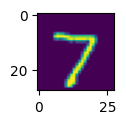

2


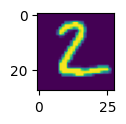

1


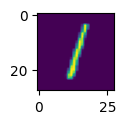

0


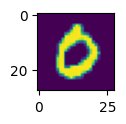

4


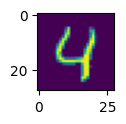

In [6]:
show5(test_loader)



# CNN Model

In [7]:
class BetterNet(nn.Module):
    def __init__(self, num_classes: int = 10, dropout: float = 0.25) -> None:
        super(BetterNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),   # 16x16
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(dropout),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),       #32x 14x14
            nn.Dropout2d(dropout),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),       #64x7x7
            nn.Dropout2d(dropout),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),                         #128x7x7
            nn.Dropout2d(dropout),
        )

        self.classifier = nn.Sequential(
            nn.Linear(128*7*7, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),

            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),

            nn.Linear(128, num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Instantiate the model
net = BetterNet()

# Visualizing Neural Network

 Total misclassified samples: 27
*   Indices of misclassified samples for label 0: []
*   Indices of misclassified samples for label 1: [2182, 6783]
*   Indices of misclassified samples for label 2: [659]
*   Indices of misclassified samples for label 3: [4443]
*   Indices of misclassified samples for label 4: [247, 1112, 2130]
*   Indices of misclassified samples for label 5: [2035, 2597, 5937, 9729]
*   Indices of misclassified samples for label 6: [1014, 3422, 4699]
*   Indices of misclassified samples for label 7: [726, 1260, 5654, 6576]
*   Indices of misclassified samples for label 8: [582, 947, 1878, 8408]
*   Indices of misclassified samples for label 9: [1232, 1901, 2293, 3869,4823]



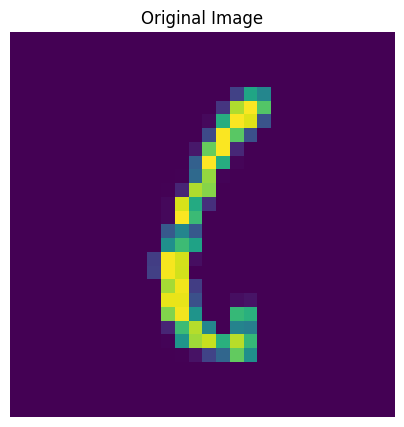

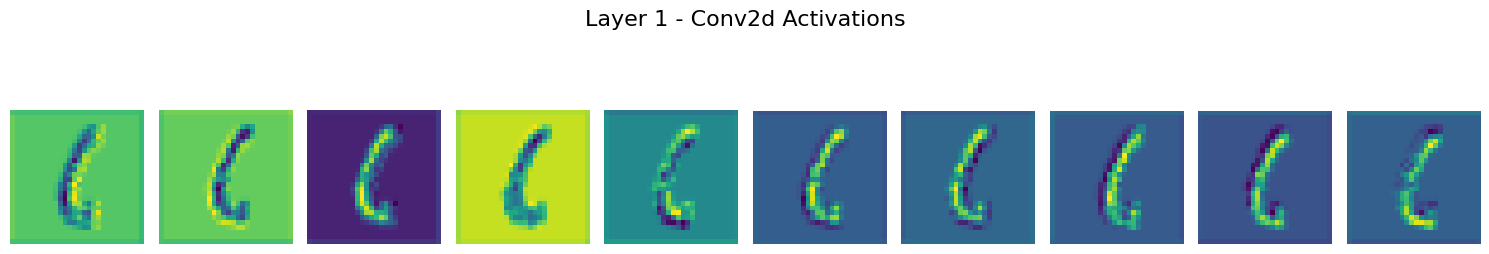

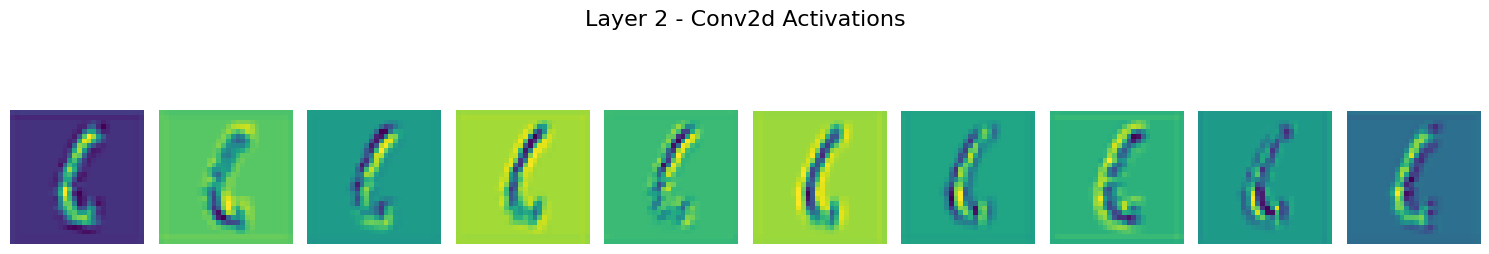

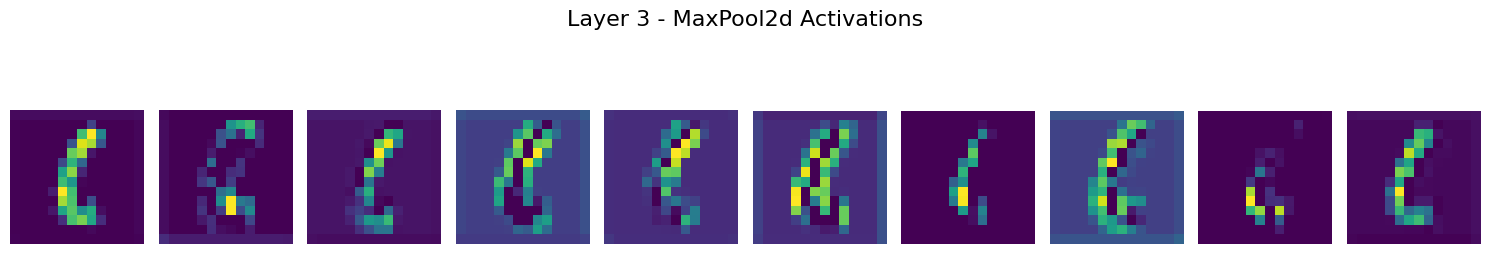

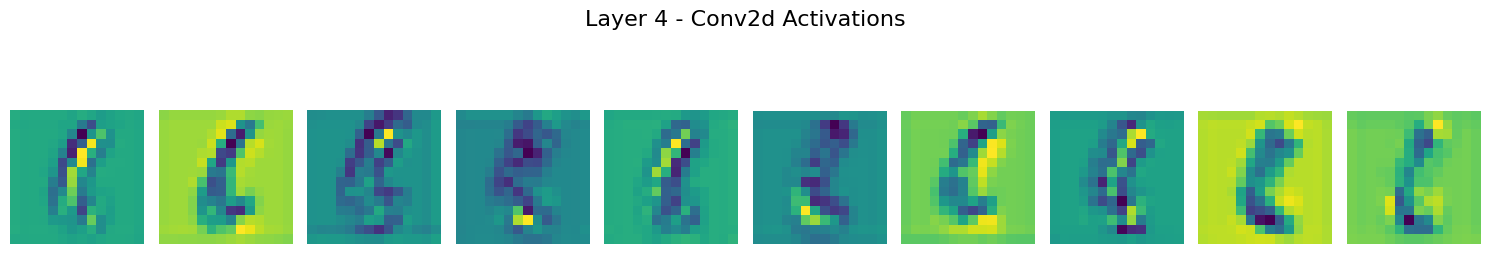

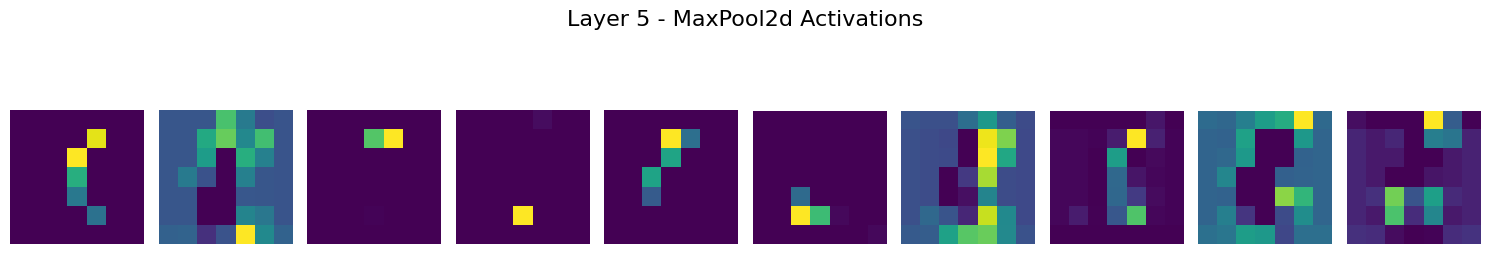

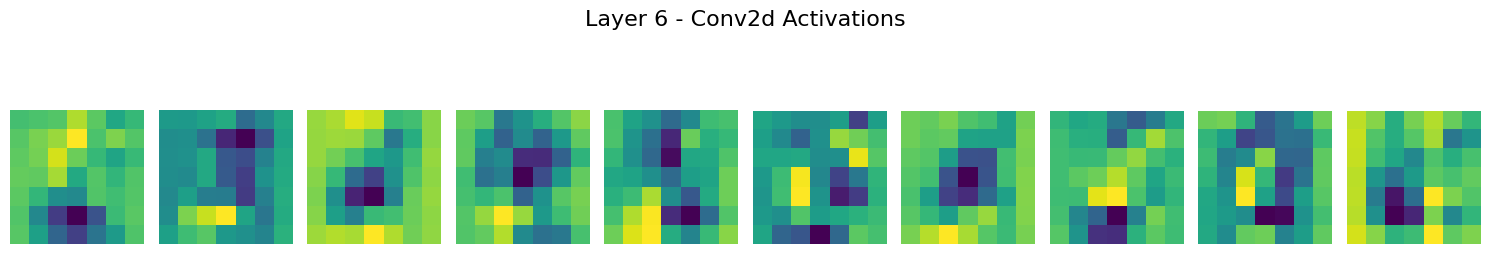

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

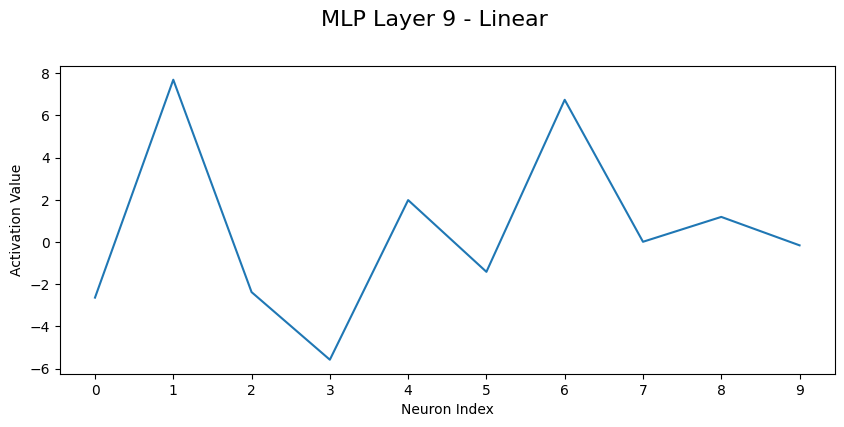

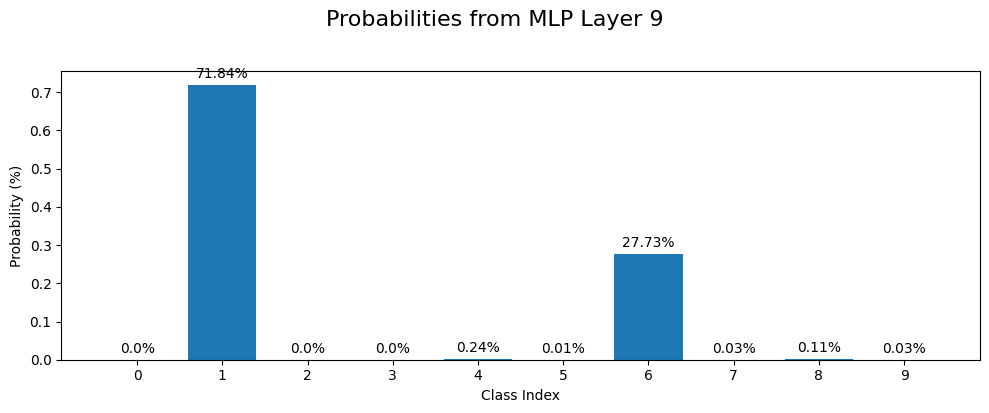

Predicted Label: 1
Actual Label: 6


In [27]:
checkpoint = torch.load('checkpoint_99.73.pth')
net.load_state_dict(checkpoint['model_state_dict'])

image, label = test_data[4699]  # get the first image
image = image.unsqueeze(0)  # add a batch dimension
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = net.to(device)
net.eval()
image = image.to(device)

# Visualizing the original image before feeding into the network
plt.figure(figsize=(5, 5))
plt.title("Original Image")
plt.imshow(image[0].permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

features_seq = net.features

def get_interested_layers(model):
    features_seq = model.features

    # Collect Conv, MaxPool layers
    feature_layers = [layer for layer in features_seq if isinstance(layer, (nn.Conv2d, nn.MaxPool2d))]

    # Collect MLP layers (from the classifier block)
    classifier_layers = [layer for layer in model.classifier if isinstance(layer, nn.Linear)]

    return feature_layers + classifier_layers



def forward_hook_fn(module, input, output, activations):
    activations.append(output)

activations = []
hooks = []

for layer in get_interested_layers(net):
    hooks.append(layer.register_forward_hook(lambda module, input, output: forward_hook_fn(module, input, output, activations)))

output = net(image)

for hook in hooks:
    hook.remove()

# Get all layers
all_layers = get_interested_layers(net)

# Visualization
for i, activation in enumerate(activations):
    num_channels = activation.size(1)
    is_image = len(activation.size()) == 4  # 4D tensor indicates an image

    if is_image:
        plt.figure(figsize=(15, 5))
        plt.suptitle(f"Layer {i + 1} - {type(all_layers[i]).__name__} Activations", size=16, y=0.8)

        for channel in range(min(num_channels, 10)):
            if activation[0, channel].numel() > 1:  # Ensure there are more than one elements to visualize
                plt.subplot(1, min(num_channels, 10), channel+1)
                plt.imshow(activation[0, channel].cpu().detach().numpy(), cmap='viridis')
                plt.axis('off')

        plt.tight_layout()
        plt.show()
    else:
        # If MLP activations are 1D (which is typical after an MLP layer)
        if len(activation.size()) == 2 and activation.size(1) == 10:
            # Plotting the activations
            plt.figure(figsize=(10, 4))
            plt.suptitle(f"MLP Layer {i + 1} - {type(all_layers[i]).__name__}", size=16, y=1.02)
            plt.plot(activation[0].cpu().detach().numpy())
            plt.xticks(range(10))  # Setting x-axis ticks to range from 0 to 9
            plt.xlabel("Neuron Index")
            plt.ylabel("Activation Value")
            plt.show()

            # Plotting the probabilities after softmax
            probs = F.softmax(activation[0], dim=0).cpu().detach().numpy()
            plt.figure(figsize=(10, 4))
            plt.suptitle(f"Probabilities from MLP Layer {i + 1}", size=16, y=1.02)
            bars = plt.bar(range(10), probs)
            plt.xticks(range(10))
            plt.xlabel("Class Index")
            plt.ylabel("Probability (%)")  # Modified label

# Annotate each bar with its probability value
            for bar in bars:
                yval = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{round(yval*100, 2)}%", ha='center', va='bottom', fontsize=10)  # Display as percentage

            plt.tight_layout()
            plt.show()

            # Extract the predicted label
            predicted_label = torch.argmax(activation[0]).item()

            # Print the predicted and actual labels
            print(f"Predicted Label: {predicted_label}")
            print(f"Actual Label: {label}")

        else:
            # In the unlikely event an MLP layer reshapes its output to 4D
            plt.figure(figsize=(10, 4))
            plt.suptitle(f"MLP Layer {i + 1} - {type(all_layers[i]).__name__} Activations", size=16, y=1.1)
            for channel in range(min(num_channels, 10)):
                if activation[0, channel].numel() > 1:  # Ensure there are more than one elements to visualize
                    plt.subplot(1, min(num_channels, 10), channel+1)
                    plt.imshow(activation[0, channel].cpu().detach().numpy(), cmap='viridis')
                    plt.axis('off')
            plt.tight_layout()
            plt.show()


#Mislabel

In [16]:
from collections import defaultdict

# 2. Pass the dataset through your model and collect predictions
all_true_labels = []
all_predicted_labels = []

with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        outputs = net(data)
        _, predicted = torch.max(outputs, 1)

        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(predicted.cpu().numpy())

# 3. Compare the predictions with the true labels
def count_misclassifications(true_labels, predicted_labels):
    misclassifications = defaultdict(int)
    misclass_indices = defaultdict(list)

    for idx, (true, predicted) in enumerate(zip(true_labels, predicted_labels)):
        if true != predicted:
            misclassifications[true] += 1
            misclass_indices[true].append(idx)  # capturing the indices of misclassifications for each label

    return dict(misclassifications), dict(misclass_indices)


import torch
import torchvision
import torchvision.transforms as transforms
from collections import defaultdict

def evaluate_misclassifications(model, root='data'):
    # 1. Load the MNIST dataset
    transform = transforms.Compose([transforms.ToTensor()])
    test_data = torchvision.datasets.MNIST(root=root, train=False, download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    # 2. Pass the dataset through your model and collect predictions
    all_true_labels = []
    all_predicted_labels = []

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)

            all_true_labels.extend(labels.cpu().numpy())
            all_predicted_labels.extend(predicted.cpu().numpy())

    # 3. Compare the predictions with the true labels
def count_misclassifications(true_labels, predicted_labels):
    misclassifications = defaultdict(int)
    misclass_indices = defaultdict(list)

    for idx, (true, predicted) in enumerate(zip(true_labels, predicted_labels)):
        if true != predicted:
            misclassifications[true] += 1
            misclass_indices[true].append(idx)  # capturing the indices of misclassifications for each label

    return dict(misclassifications), dict(misclass_indices)

# 4. Count the misclassifications for each label
misclass_count, misclass_idx_dict = count_misclassifications(all_true_labels, all_predicted_labels)
# Calculate total misclassifications
total_misclassified = sum(misclass_count.values())

# Sort and display results
sorted_misclass_count = dict(sorted(misclass_count.items()))
print("Label  | Misclassifications")
print("-------------------------")
for label in range(10):
    count = sorted_misclass_count.get(label, 0)  # Get count, or 0 if label not in dictionary
    print(f"{label:5} | {count}")
print("-------------------------")
print(f"Total misclassified samples: {total_misclassified}")

# display the misclassified indices for a particular label, you can do:
for label in range(10):
    print(f"Indices of misclassified samples for label {label}: {misclass_idx_dict.get(label, [])}")




Label  | Misclassifications
-------------------------
    0 | 0
    1 | 2
    2 | 1
    3 | 1
    4 | 3
    5 | 4
    6 | 3
    7 | 4
    8 | 4
    9 | 5
-------------------------
Total misclassified samples: 27
Indices of misclassified samples for label 0: []
Indices of misclassified samples for label 1: [2182, 6783]
Indices of misclassified samples for label 2: [659]
Indices of misclassified samples for label 3: [4443]
Indices of misclassified samples for label 4: [247, 1112, 2130]
Indices of misclassified samples for label 5: [2035, 2597, 5937, 9729]
Indices of misclassified samples for label 6: [1014, 3422, 4699]
Indices of misclassified samples for label 7: [726, 1260, 5654, 6576]
Indices of misclassified samples for label 8: [582, 947, 1878, 8408]
Indices of misclassified samples for label 9: [1232, 1901, 2293, 3869, 4823]


#Top 20 number guess wrong

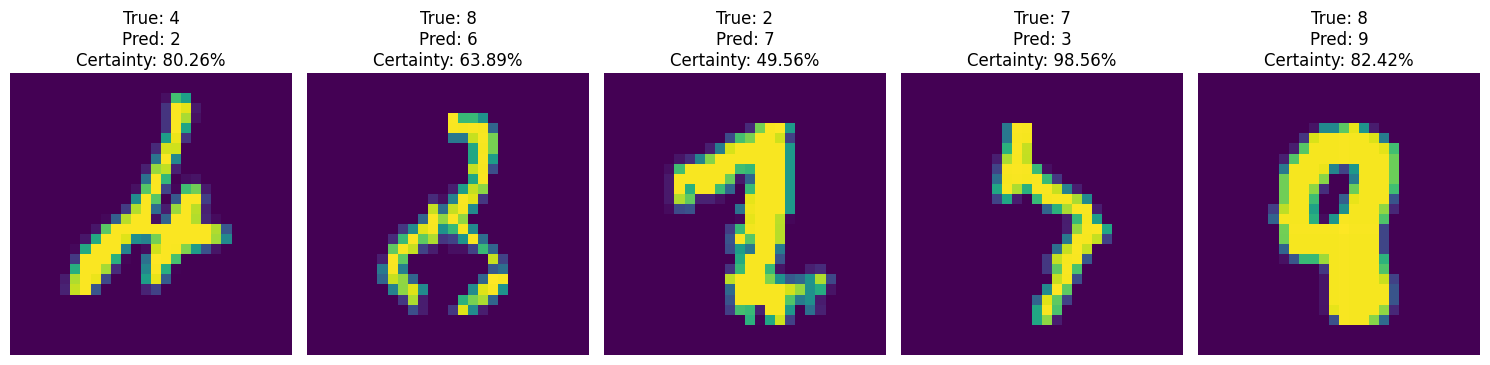

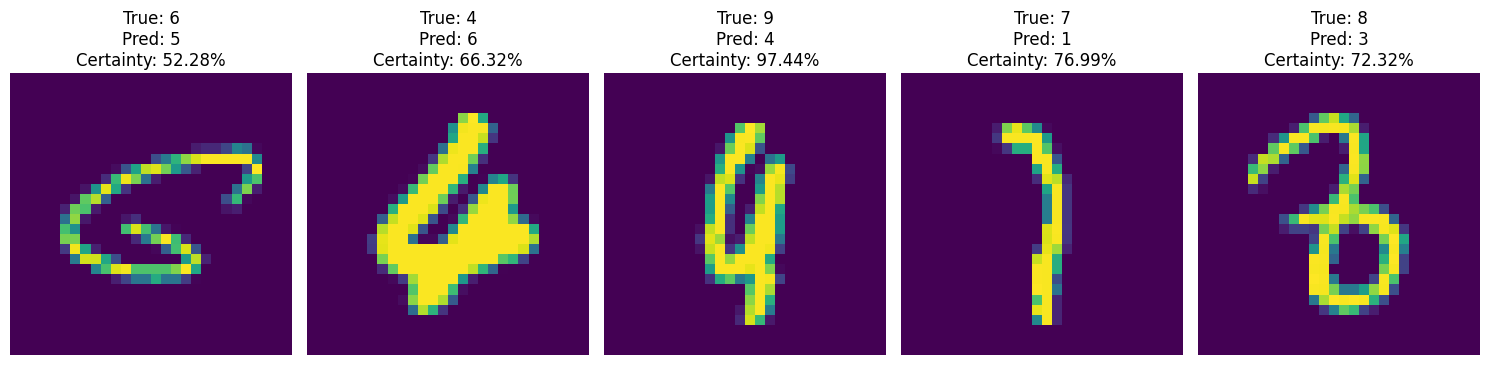

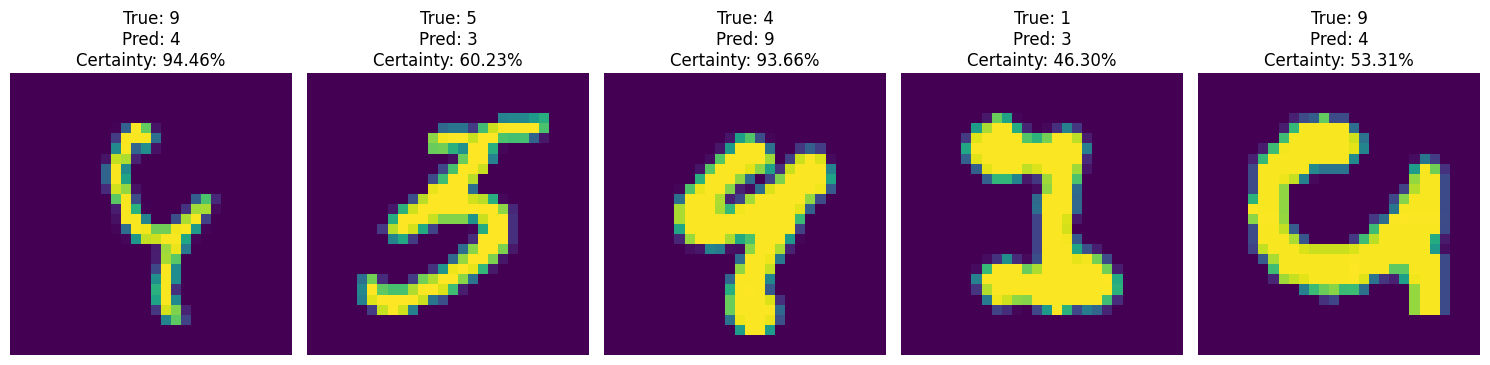

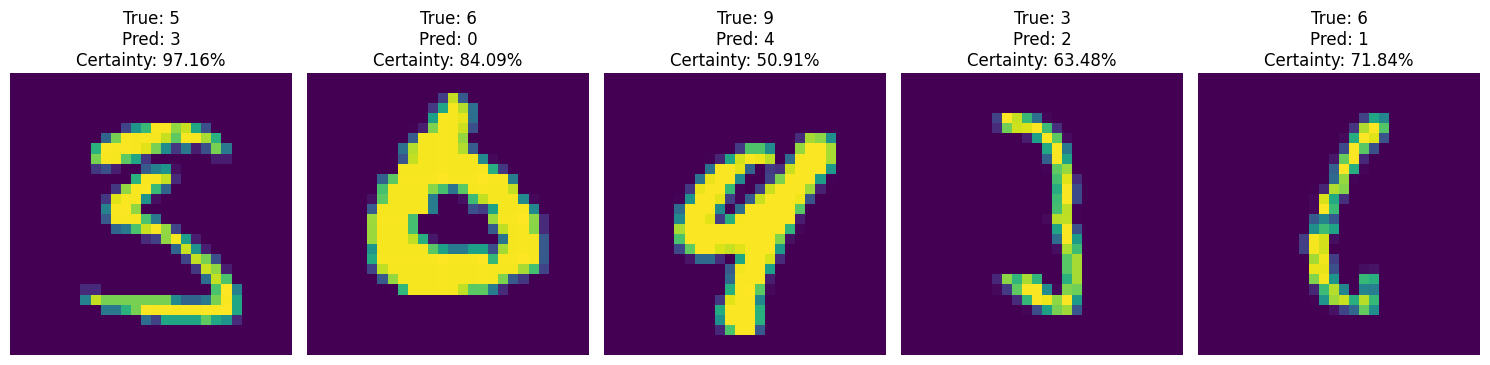

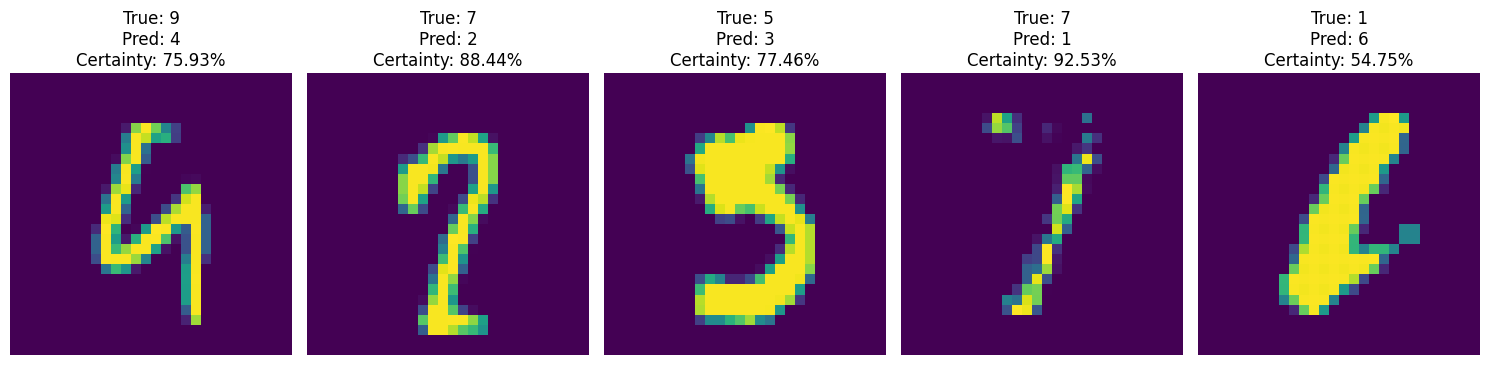

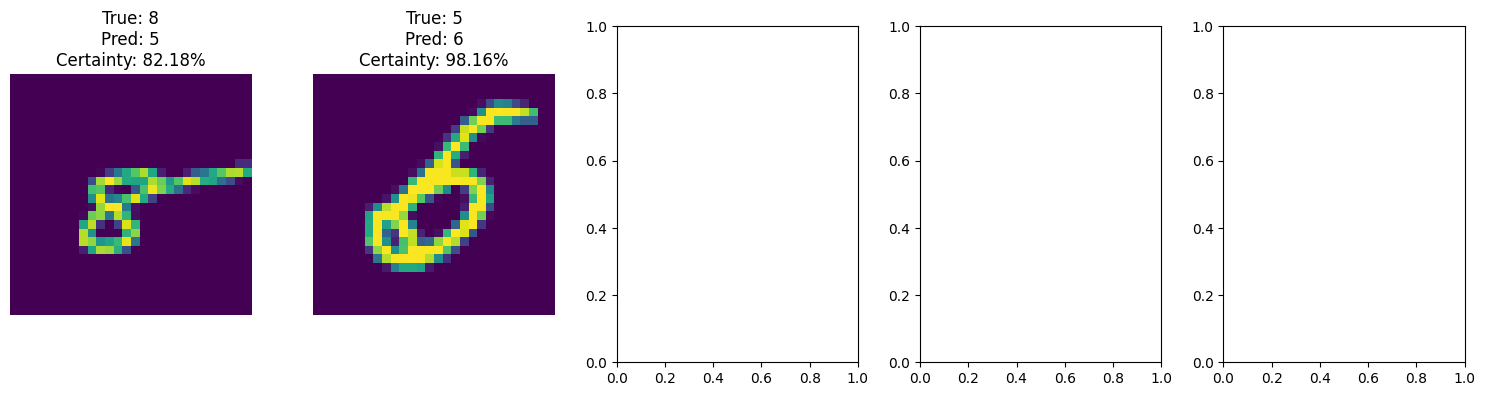

In [25]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

net.eval()

mismatch_images = []
mismatch_info = []

# Iterate over the test data
for inputs, true_labels in test_loader:
    inputs, true_labels = inputs.to(device), true_labels.to(device)

    # Get model predictions
    outputs = net(inputs)

    # Compute the softmax probabilities
    probabilities = F.softmax(outputs, dim=1)

    # Get the predicted class (the one with the highest probability)
    _, predicted_labels = outputs.max(1)

    # Find where the model's prediction doesn't match the true label
    mismatches = (predicted_labels != true_labels).nonzero(as_tuple=True)[0]

    # For each mismatch, store the image and info for later display
    for mismatch in mismatches:
        mismatch_images.append(inputs[mismatch].cpu())
        mismatch_info.append(
            (true_labels[mismatch].item(),
             predicted_labels[mismatch].item(),
             100 * probabilities[mismatch].max().item()) # as a percentage
        )

# Now, display the images 5 per row using matplotlib
for i in range(0, len(mismatch_images), 5):
    fig, axs = plt.subplots(1, 5, figsize=(15, 4))
    for j in range(5):
        if i + j < len(mismatch_images):
            img, (true, pred, certainty) = mismatch_images[i+j], mismatch_info[i+j]
            axs[j].imshow(img.permute(1, 2, 0).numpy())
            axs[j].axis('off') # turn off the axis
            axs[j].set_title(f"True: {true}\nPred: {pred}\nCertainty: {certainty:.2f}%")
    plt.tight_layout()
    plt.show()
